In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
import html
import random
import os
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


True

In [3]:
# TensorFlow + Hugging Face
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from transformers import (
    TFDistilBertForSequenceClassification,
    DistilBertTokenizer,
    DistilBertConfig,
    create_optimizer
)

SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## BiLSTM

In [4]:
class BiLSTMModel:
    def __init__(self, max_features=10000, max_len=250, embedding_dim=128):
        self.max_features = max_features
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
        self.model = None

    def prepare_sequences(self, texts):
        sequences = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')

    def build_model(self):
        """Simplified architecture with better regularization"""
        model = Sequential([
            Embedding(self.max_features, self.embedding_dim, input_length=self.max_len),
            SpatialDropout1D(0.2),  # Better for embeddings
            Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.0)),
            Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        self.model = model
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=15, batch_size=64):
        # Fit tokenizer ONLY on training data
        self.tokenizer.fit_on_texts(X_train)
        X_train_seq = self.prepare_sequences(X_train)
        X_val_seq = self.prepare_sequences(X_val)

        early_stop = EarlyStopping(
            monitor='val_loss', 
            patience=4, 
            restore_best_weights=True,
            verbose=1
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=2, 
            min_lr=1e-6,
            verbose=1
        )

        history = self.model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        return history

    def predict(self, texts):
        sequences = self.prepare_sequences(texts)
        predictions = self.model.predict(sequences, verbose=0)
        return (predictions > 0.5).astype(int).flatten()


## DistilBert

In [5]:
class DistilBertModel:
    def __init__(self, model_name='distilbert-base-uncased', max_length=256):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = None

    def prepare_model(self, learning_rate=2e-5, weight_decay=0.01,
                      freeze_layers=4, dropout_rate=0.3):
        config = DistilBertConfig.from_pretrained(
            self.model_name,
            num_labels=2,
            dropout=dropout_rate,
            attention_dropout=dropout_rate
        )
        self.model = TFDistilBertForSequenceClassification.from_pretrained(
            self.model_name, config=config
        )

        try:
            transformer_layers = self.model.distilbert.transformer.layer
            for layer in transformer_layers[:freeze_layers]:
                layer.trainable = False
            print(f"Froze first {freeze_layers} transformer layers in DistilBERT.")
        except AttributeError:
            print("Warning: Could not access transformer layers for freezing.")

        optimizer, _ = create_optimizer(
            init_lr=learning_rate,
            num_train_steps=1000,
            num_warmup_steps=100,
            weight_decay_rate=weight_decay
        )

        self.model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print("Model compiled successfully.")

    def encode_texts(self, texts, labels=None, batch_size=32, shuffle=False):
        encodings = self.tokenizer(
            list(texts),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='tf'
        )
        if labels is not None:
            dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
        else:
            dataset = tf.data.Dataset.from_tensor_slices(dict(encodings))

        if shuffle:
            dataset = dataset.shuffle(2048)
        return dataset.batch(batch_size)

    def train(self, X_train, y_train, X_val, y_val,
              epochs=10, batch_size=16, early_stopping_patience=2):

        print("Preparing datasets...")
        train_dataset = self.encode_texts(X_train, y_train, batch_size=batch_size, shuffle=True)
        val_dataset = self.encode_texts(X_val, y_val, batch_size=batch_size)

        steps_per_epoch = len(X_train) // batch_size
        num_train_steps = steps_per_epoch * epochs
        num_warmup_steps = num_train_steps // 10

        optimizer, _ = create_optimizer(
            init_lr=2e-5,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            weight_decay_rate=0.01
        )
        self.model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        )

        # Gradual unfreezing callback
        gradual_unfreeze = GradualUnfreezing(self, start_epoch=3)

        print("Starting training...")
        history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=[early_stop, gradual_unfreeze]
        )

        print("Training complete.")
        return {k: v for k, v in history.history.items()}

    def predict(self, texts, batch_size=16):
        dataset = self.encode_texts(texts, labels=None, batch_size=batch_size)
        preds_output = self.model.predict(dataset)
        logits = preds_output.logits if hasattr(preds_output, 'logits') else preds_output[0]
        probs = tf.nn.softmax(logits, axis=-1).numpy()
        preds = np.argmax(probs, axis=-1)
        return preds

class GradualUnfreezing(tf.keras.callbacks.Callback):
    def __init__(self, model_wrapper, start_epoch=3):
        super().__init__()
        self.model_ref = model_wrapper
        self.start_epoch = start_epoch

    def on_epoch_begin(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            transformer_layers = self.model_ref.model.distilbert.transformer.layer
            layers_to_unfreeze = min(epoch - self.start_epoch + 1, len(transformer_layers))
            for layer in transformer_layers[-layers_to_unfreeze:]:
                layer.trainable = True
            print(f"\n🧠 Gradual unfreezing: {layers_to_unfreeze} top layers now trainable.")


## Model Evaluation

In [6]:
class ModelEvaluator:
    def __init__(self):
        pass

    def evaluate_model(self, y_true, y_pred, model_name):
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"\nClassification Report for {model_name}:")
        print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

        return {
            'accuracy': accuracy,
            'f1': f1,
            'classification_report': classification_report(y_true, y_pred, output_dict=True)
        }

    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        return cm

    def compare_models(self, results_dict):
        models = list(results_dict.keys())
        metrics = ['accuracy', 'f1']
        comparison_data = []
        for model in models:
            for metric in metrics:
                comparison_data.append({
                    'Model': model,
                    'Metric': metric.capitalize(),
                    'Score': results_dict[model][metric]
                })
        df_comparison = pd.DataFrame(comparison_data)
        plt.figure(figsize=(10, 5))
        sns.barplot(data=df_comparison, x='Metric', y='Score', hue='Model')
        plt.title('Model Performance Comparison')
        plt.ylim(0, 1)
        plt.show()
        return df_comparison


In [7]:
use_gpu_check = True
if use_gpu_check:
    gpus = tf.config.list_physical_devices('GPU')
    print("TensorFlow detected GPUs:", gpus)

with open('imdb_processed.pkl', 'rb') as f:
    df_processed, label_encoder = pickle.load(f)

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_processed['processed_text'].values,
    df_processed['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df_processed['label'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

TensorFlow detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training set: 31732
Validation set: 7933
Test set: 9917


In [8]:
evaluator = ModelEvaluator()
results = {}


TRAINING BiLSTM MODEL


2025-11-15 09:54:19.159397: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-15 09:54:19.159423: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-15 09:54:19.159429: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-15 09:54:19.159455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-15 09:54:19.159470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2025-11-15 09:54:23.337834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-15 09:54:23.436358: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


496/496 [==============================] - 46s 83ms/step - loss: 0.4994 - accuracy: 0.8062 - val_loss: 0.3529 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 2/15
496/496 [==============================] - 38s 76ms/step - loss: 0.2904 - accuracy: 0.8976 - val_loss: 0.3150 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 3/15
496/496 [==============================] - 37s 74ms/step - loss: 0.2758 - accuracy: 0.9013 - val_loss: 0.3555 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 4/15
496/496 [==============================] - 37s 74ms/step - loss: 0.2194 - accuracy: 0.9257 - val_loss: 0.3130 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 5/15
496/496 [==============================] - 37s 74ms/step - loss: 0.1843 - accuracy: 0.9406 - val_loss: 0.3471 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 6/15
496/496 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9520
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
496/496 [==============================] - 36s 74ms/st

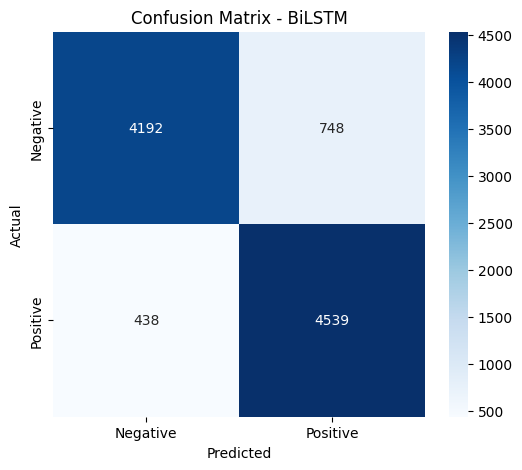

array([[4192,  748],
       [ 438, 4539]])

In [9]:
print("\n" + "="*60)
print("TRAINING BiLSTM MODEL")
print("="*60)

bilstm_model = BiLSTMModel(max_features=10000, max_len=250, embedding_dim=128)
bilstm_model.build_model()
bilstm_history = bilstm_model.train(X_train, y_train, X_val, y_val, epochs=15, batch_size=64)

print("\nEvaluating BiLSTM model")
bilstm_predictions = bilstm_model.predict(X_test)
results['BiLSTM'] = evaluator.evaluate_model(y_test, bilstm_predictions, 'BiLSTM')
evaluator.plot_confusion_matrix(y_test, bilstm_predictions, 'BiLSTM')


 TRAINING TensorFlow DistilBERT MODEL


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Froze first 4 transformer layers in DistilBERT.
Model compiled successfully.
Preparing datasets...
Starting training...
Epoch 1/10
1000/1000 [==============================] - 423s 414ms/step - loss: 0.5686 - accuracy: 0.6701 - val_loss: 0.4275 - val_accuracy: 0.8059
Epoch 2/10
1000/1000 [==============================] - 404s 404ms/step - loss: 0.3789 - accuracy: 0.8315 - val_loss: 0.3550 - val_accuracy: 0.8476
Epoch 3/10
1000/1000 [==============================] - 938s 939ms/step - loss: 0.3152 - accuracy: 0.8679 - val_loss: 0.3444 - val_accuracy: 0.8577

🧠 Gradual unfreezing: 1 top layers now trainable.
Epoch 4/10
1000/1000 [==============================] - 398s 398ms/step - loss: 0.2602 - accuracy: 0.8946 - val_loss: 0.3463 - val_accuracy: 0.8640

🧠 Gradual unfreezing: 2 top layers now trainable.
Epoch 5/10
1000/1000 [==============================] - 402s 402ms/step - loss: 0.2272 - accuracy: 0.9114 - val_loss: 0.3521 - val_accuracy: 0.8658
Epoch 5: early stopping
Training compl

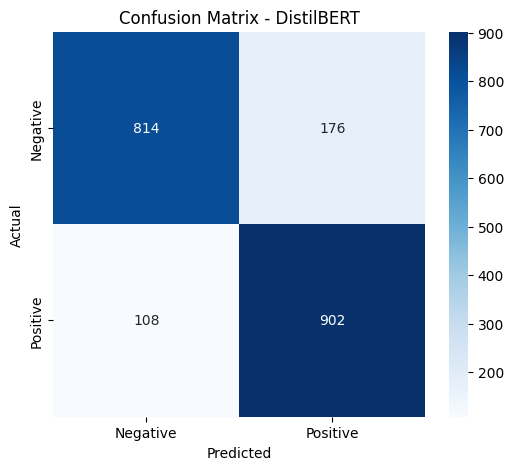

array([[814, 176],
       [108, 902]])

In [10]:
print("\n TRAINING TensorFlow DistilBERT MODEL")

sample_size = min(8000, len(X_train))
rng = np.random.default_rng(42)
indices = rng.choice(len(X_train), sample_size, replace=False)


# Initialize and prepare model
distil_model = DistilBertModel(max_length=128)
distil_model.prepare_model(
    learning_rate=2e-5,
    freeze_layers=4,
    dropout_rate=0.3
)


# Train with early stopping and gradual unfreezing
distil_history = distil_model.train(
    X_train[indices],
    y_train[indices],
    X_val,
    y_val,
    epochs=10,
    batch_size=8,
    early_stopping_patience=2
)

test_size = min(2000, len(X_test))
print("Evaluating DistilBERT model...")
distil_predictions = distil_model.predict(X_test[:test_size], batch_size=16)
results['DistilBERT'] = evaluator.evaluate_model(y_test[:test_size], distil_predictions, 'DistilBERT')
evaluator.plot_confusion_matrix(y_test[:test_size], distil_predictions, 'DistilBERT')



MODEL COMPARISON


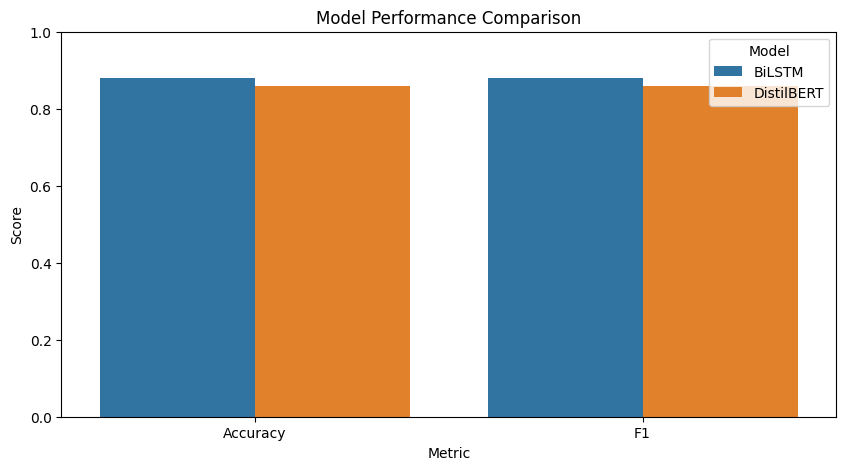


Model Comparison Summary:
Metric      Accuracy        F1
Model                         
BiLSTM      0.880407  0.880276
DistilBERT  0.858000  0.857787


In [11]:
print("\n" + "="*40)
print("MODEL COMPARISON")
print("="*40)

comparison_df = evaluator.compare_models(results)
print("\nModel Comparison Summary:")
print(comparison_df.pivot(index='Model', columns='Metric', values='Score'))


In [12]:
print("\n" + "="*40)
print("FINAL REPORT")
print("="*40)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")

best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest performing model: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.4f})")

print("\nAnalysis Complete!")



FINAL REPORT

BiLSTM:
  Accuracy: 0.8804
  F1 Score: 0.8803

DistilBERT:
  Accuracy: 0.8580
  F1 Score: 0.8578

Best performing model: BiLSTM (Accuracy: 0.8804)

Analysis Complete!
